In [1]:
from jupyterquiz import display_quiz
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt

# An Introduction

Characterization is concerned with the following main question: what exactly did the quantum computer do? This may manifest in a few ways:

- What is the state $\rho$ of the quantum computer?
- What is the operation $\mathcal O$ that is being performed by the quantum computer?

or

- How close is the quantum computer's state to my state?
- How _accurate_ is my desired operation $U$? 

## State Tomography

> What is the state $\rho$ of the quantum computer?

Let us introduce state tomography by walking through a simple qubit example.

Suppose we start in an arbitrary qubit _density_ state, which we may write as:

$$
\rho = \frac{1}{2}(I + a_x\sigma_x + a_y\sigma_y + a_z\sigma_z)
$$

where $\vec{a}$ is a real number. So how would be figure out coefficients $\vec{a}$? Let us take a look at the expectation value of $\sigma_x$:

$$
\begin{align}
\expectationvalue{\sigma_x} &= \mathrm{Tr} (\rho \sigma_x) \\
&= \frac{1}{2} \left( \mathrm{Tr}(I\sigma_x) + a_x \mathrm{Tr}(\sigma_x \sigma_x) + a_y \mathrm{Tr} (\sigma_y \sigma_x) + a_z \mathrm{Tr}(\sigma_z\sigma_x) \right) \\
&= \frac{1}{2} (a_x \cdot 2) = a_x
\end{align}
$$

```{note}
For an observable $M$, $\expectationvalue{M} = \mathrm{Tr}(\rho M)$
and
Pauli matrices follow the identity $\mathrm{Tr}(\sigma_\alpha \sigma_\beta) = 2\delta_{\alpha,\beta}$
```

We have shown that the expectation values of the Pauli matrices (same deduction for $\sigma_y$ and $\sigma_x$ as above) has a direct relation with the density matrix of the state. Therefore by computing the expectation values of an appropriate set of observables we can compute the density state.

Now, we can compute the expectation value by performed repeated measurements. We can project the state into each basis, repeating the experiment a large number of times, and using the resulting counts to get the expectation value.

```{note}
Given an observable $M$, we can 

$$
\begin{align}
\bra{\psi} M \ket{\psi} &= \bra{\psi} U^\dagger \Lambda U \ket{\psi} = \bra{\psi^\prime} \Lambda \ket{\psi^\prime} \\
&= \sum_i \braket{\psi^\prime}{i}\bra{i}\Lambda\ket{i}\braket{i}{\psi^\prime} = \sum_i \lambda_i |\bra{i}\ket{\psi^\prime}|^2
\end{align}
$$ (eq:observable)

Since $M$ is Hermitian, we are able to [diagonalize](https://en.wikipedia.org/wiki/Hermitian_matrix#Diagonalizable) it by a unitary matrix $U$ and a diagonal matrix with real entries $\Lambda$ (corresponding to eigenvalues). We let the quantum computer perform the operation $U$, and then measure in a standard basis, $\ket{i}$. We can then recover the expectation value of $M$ by multiplying the outcomes by the eigenvalues $\lambda_i$. 
```

> TL;DR:
> 1. Expectation values of a set of observables let us deduce the density matrix
> 2. Through repeated measurements we can estimate the expectation values


### Python Example

Let us now walk for an example of performing state tomography on arbitrary dimensions. First, we are using [`liepy`](https://github.com/qutieelib/lie), a library that has convenience functions to generate various matrix groups.

In [2]:
import liepy as lp

For a $d$-dimensional quantum system, let use the [generalized Gell-Mann matrices](https://mathworld.wolfram.com/GeneralizedGell-MannMatrix.html) to create the set observables $\{M\}$

In [3]:
def qudit_tomography(d: int = 2) -> list[np.ndarray]:
    """
    Creates the Hermitian matrix basis for a single qudit.

    Parameters
    ----------
    d : int, optional
        Dimension of qudit, defaults to a qubit (d = 2)
    """
    basis = lp.gen_gellmann(d)
    basis = [-1j * b for b in basis]
    basis = [np.eye(d)] + basis
    return basis

We also create a function that simply computes the tensor basis for several qudits

In [4]:
def qudits_tomography(d: int = 2, n: int = 1) -> list[np.ndarray]:
    """
    Creates the Hermitian matrix basis for a single qudit.

    Parameters
    ----------
    d : int, optional
        Dimension of qudit, defaults to a qubit (d = 2)
    n : int
        Number of qudits
    """

    qudit_basis = qudit_tomography(d)
    tensors = product(qudit_basis, repeat=n)
    basis = []
    for t in tensors:
        tensor = reduce(lambda x, y: np.kron(x, y), t)
        basis.append(tensor)

    return basis

Now we create a class that holds information about the observables $\{M\}$, but also computes the unitary operators following {eq}`eq:observable`. We also define functions that (a) takes a set of probabilities (from an experiment) and converts them to expectation values {eq}`eq:observable`, and (b) computes the density matrix from expectation values.

In [5]:
from itertools import product
from functools import reduce

class QuditTomography(object):
    def __init__(self, d: int = 2, n: int = 1):
        self.d = d
        self.n = n
        self.dim = d ** n
        self.basis = qudits_tomography(d, n)
        self.A = np.stack([b.flatten().conj() for b in self.basis])

        # Compute the Unitary operators for change-of-basis
        eigh = [np.linalg.eig(b) for b in self.basis]
        eigh = [*zip(*eigh)]
        self.eigs, self.Us = eigh

        # Need to diagonalize such that U^dag L U = H
        # but default numpy is U L U^dag = H
        # so we make U be the conjugate transpose
        self.Us = [u.conj().T for u in self.Us]

    def fit(self, probabilities: list[np.ndarray]):
        """
        Given the probabilities for each experiment, 
        compute the density matrix via linear inversion

        Parameters
        ----------
        probabilities: list[np.ndarray]
            A list of experiments' probability results
        """
        expectations = np.array([np.sum(e @ p)
                                for e, p in zip(self.eigs, probabilities)])
        return self.fit_expectations(expectations)

    def fit_expectations(self, expectations: np.ndarray):
        """
        Use linear inversion to fit a density matrix rho from expectation values

        Parameters
        ----------
        expectations: np.ndarray
            An array of expectation values
        """
        #expectations = np.atleast_2d(expectations[:]).T
        rho = np.linalg.pinv(self.A.T @ self.A) @ self.A.T @ expectations
        rho = rho.reshape(self.dim, self.dim)
        return rho

#### Fake experiment: a qubit

Suppose we have a random quantum state

  (0, 0)	(0.08692585885419261+0j)
  (0, 1)	(-0.14234979249429836+0.18688131535102628j)
  (1, 0)	(-0.14234979249429836-0.18688131535102628j)
  (1, 1)	(0.9130741411458073+0j)


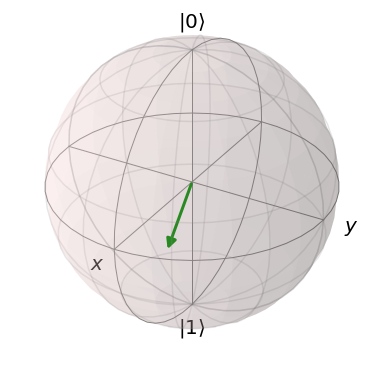

In [6]:
rho = qp.rand_dm_hs(2)
print(rho.data)
b = qp.Bloch()
b.add_states(rho)
b.show()

Let us recover it using quantum state tomography. First we compute the probabilities for the different observables

In [7]:
tomo = QuditTomography(2, 1)
Us = tomo.Us

rho = rho.data.toarray()

states = []
for U in Us:
    state = U @ rho @ U.conj().T
    states.append(state)

# define projection operators in the standard basis
P = [np.array([[1, 0], [0, 0]]), np.array([[0, 0], [0, 1]])]

# compute the probabilites after basis transformation
probabilities = [[np.trace(state @ p).real for p in P] for state in states]

In [8]:
# https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars

def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

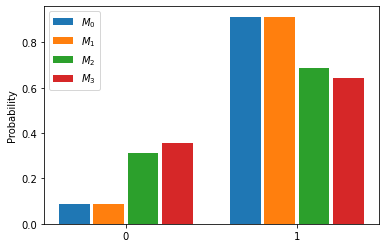

In [9]:
labels = ['0', '1']

data = {r"$M_{}$".format(i): p for i, p in enumerate(probabilities)}
fig, ax = plt.subplots()
bar_plot(ax, data, total_width=.8, single_width=.9)
ax.set_xticks(range(2), ["0", "1"])
plt.ylabel("Probability")

plt.show()

Now let us reconstruct the state from these probabilities

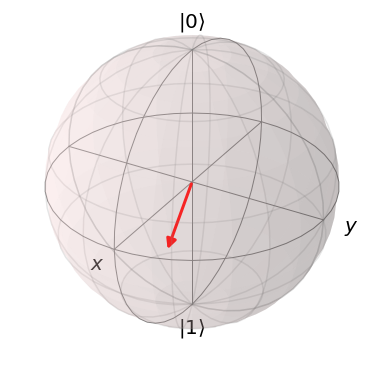

In [10]:

rho_r = tomo.fit(probabilities)

b = qp.Bloch()
b.vector_color = ['r']
b.add_states(qp.Qobj(rho_r))
b.show()

#### Fake experiment: two qutrits

In [11]:
d = 3
n = 2

rho = qp.rand_dm_hs(d**n)

In [12]:
tomo = QuditTomography(d, n)
Us = tomo.Us

rho = rho.data.toarray()

states = []
for U in Us:
    state = U @ rho @ U.conj().T
    states.append(state)

# define projection operators in the standard basis
basis = []
for d_i in range(d):
    b = np.zeros((d,d))
    b[d_i, d_i] = 1
    basis.append(b)
basis = product(basis, repeat=n)
P = []
for t in basis:
    p = reduce(lambda x, y: np.kron(x, y), t)
    P.append(p)


# compute the probabilites after basis transformation
probabilities = [[np.trace(state @ p).real for p in P] for state in states]

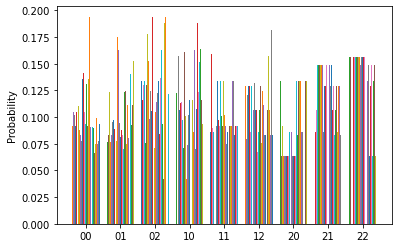

In [13]:
labels = ['0', '1', '2']
labels = [x[0] + x[1] for x in product(labels, repeat=n)]

data = {r"$M_{}$".format(i): p for i, p in enumerate(probabilities)}
fig, ax = plt.subplots()
bar_plot(ax, data, total_width=.8, single_width=.9, legend=False)
ax.set_xticks(range(d**n), labels)
plt.ylabel("Probability")

plt.show()

In [14]:
rho_r = tomo.fit(probabilities)

print(f"Is our fitted state close to original? {np.allclose(rho_r, rho)}")

Is our fitted state close to original? True


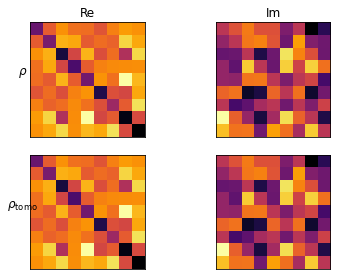

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True)

im = axes[0, 0].matshow(rho.real, cmap=plt.cm.inferno_r)
im = axes[0, 1].matshow(rho.imag, cmap=plt.cm.inferno_r)

im = axes[1, 0].matshow(rho_r.real, cmap=plt.cm.inferno_r)
im = axes[1, 1].matshow(rho_r.imag, cmap=plt.cm.inferno_r)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

axes[0, 0].set_ylabel(r"$\rho$", rotation=0, size='large')
axes[1, 0].set_ylabel(r"$\rho_\mathrm{tomo}$", rotation=0, size='large')

axes[0, 0].set_title("Re", size='large')
axes[0, 1].set_title("Im", size='large')

fig.tight_layout()